For blastn
Max target sequences=1000
Expect threshold=0.0001

Download sequences instead of alignment after blast search to get a non-gapped fasta file

In [ ]:
# %%bash
# transeq seqdump.txt
# # named translated query

# mafft translated_dump.txt > aligned.txt

In [2]:
import sys
from fasta_iterator_class import FASTAReader
aligned=FASTAReader(open('aligned.txt','r'))
na_seq=FASTAReader(open('seqdump.txt','r'))



# Q3
list_na=[]
list_aa=[]
for aa_seq, na_seq in zip(aligned, na_seq):
    aligned_na=[]
    aligned_aa=[]
    aa_counter=0
    length=len(aa_seq[1].replace("-", ""))
    #print(length)
    for amino_acid in aa_seq[1]:  # loop through the amino acids in each aa alignment
        codon=na_seq[1][3*aa_counter:3*aa_counter+3]
        #print(codon)
        if aa_counter==length:
            list_na.append(''.join(aligned_na))
            list_aa.append(''.join(aligned_aa))
            break
        else:
            aligned_aa.append(amino_acid)
            if amino_acid=='-':
                #print("gap")
                aligned_na.append('---')
            else:
                #print("not gap")
                aligned_na.append(codon)
                aa_counter+=1


In [7]:
# Q4

# make a function to split a DNA sequence into codons
def get_codon(aligned_dna): #input single aligned DNA sequence
    codon_list=[]
    codon_pos=[]
    codon_counter=0
    assert type(aligned_dna)==str, "input sequence as a string"
    assert ('A' in aligned_dna) or ('T' in aligned_dna) \
    or ('C' in aligned_dna) or ('G' in aligned_dna), "does not look like a sequence"
    for i in range(0, len(aligned_dna)//3):
        codon_counter+=1
        codon_list.append(aligned_dna[3*i:3*i+3])
        if aligned_dna[3*i:3*i+3]=='---':
            continue
        else:
            codon_pos.append(codon_counter)
            
    return (codon_pos, codon_list)

In [9]:
import pandas as pd

def split(word): 
    return [char for char in word]  

q_dna=list_na[0]
q_codon=get_codon(q_dna)[1]
q_codon_pos=get_codon(q_dna)[0]

q_translated=list_aa[0]
q_aa=split(q_translated)

seq_data=[]
for dna_seq in list_na:
    seq_data.append(get_codon(dna_seq)[1])
df = pd.DataFrame(seq_data)
df=df.truncate(before=q_codon_pos[0]-1,after=q_codon_pos[-1]-1, axis=1)





aa_data=[]
for aa_seq in list_aa:
    aa_data.append(split(aa_seq))

df_aa=pd.DataFrame(aa_data)
df_aa=df_aa.truncate(before=q_codon_pos[0]-1,after=q_codon_pos[-1]-1, axis=1)

In [10]:


list_dS=[]
list_dN=[]

for p in q_codon_pos:
    mutations=999-sum(df[p-1]==q_codon[p-1])
    dS=sum((df_aa[p-1]==q_aa[p-1]) & ~(df[p-1]==q_codon[p-1]))
    dN=mutations-dS
    list_dS.append(dS)
    list_dN.append(dN)

In [11]:
import numpy as np
list_dN=np.array(list_dN)
list_dS=np.array(list_dS)
D=list_dN-list_dS

ratio=list_dN/list_dS


In [12]:
from scipy import stats
Zscore=stats.zscore(D)

ratio_sig=[]
ratio_insig=[]
x_sig=[]
x_insig=[]

# for two-tailed distribution, p=0.05 corresponds to Z score of 1.96
for i in range(1,len(D)):
    if Zscore[i-1]>=1.96:
        x_sig.append(q_codon_pos[i-1])
        ratio_sig.append(ratio[i-1])
    else:
        x_insig.append(q_codon_pos[i-1])
        ratio_insig.append(ratio[i-1])

/home/pyrococci/miniconda3/envs/cmdb/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/home/pyrococci/miniconda3/envs/cmdb/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log2
  after removing the cwd from sys.path.


Text(0, 0.5, 'log2 dN/dS')

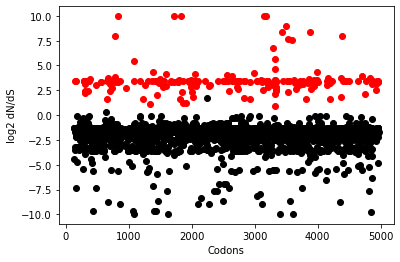

In [14]:
import matplotlib.pyplot as plt

plt.scatter(x_sig,np.log2(ratio_sig),color='red')
plt.scatter(x_insig,np.log2(ratio_insig),color='black')
plt.xlabel('Codons')
plt.ylabel('log2 dN/dS')

